In [1]:
import json
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Define directory containing JSON files
json_dir = "Data"

# Preprocess JSON data (reusing your function)
def preprocess_game_data(data):
    frames = data.get('rounds', {}).get('0', {}).get('clock', [])
    ball_control = data.get('rounds', {}).get('0', {}).get('ball_control', [])
    boost_usage = data.get('rounds', {}).get('0', {}).get('boost_value', [])
    shots_on_goal = data.get('rounds', {}).get('0', {}).get('shots_on_goal', [])
    saves = data.get('rounds', {}).get('0', {}).get('saves', [])
    
    max_length = max(len(frames), len(ball_control), len(boost_usage), len(shots_on_goal), len(saves))
    
    def adjust_length(lst, fill_value):
        return lst + [fill_value] * (max_length - len(lst)) if len(lst) < max_length else lst
    
    frames = adjust_length(frames, [0, '0:00'])
    ball_control = adjust_length(ball_control, [0, False])
    boost_usage = adjust_length(boost_usage, [0, 0])
    shots_on_goal = adjust_length(shots_on_goal, [0, False])
    saves = adjust_length(saves, [0, False])
    
    df = pd.DataFrame({
        'frame': [f[0] for f in frames],
        'ball_control': [bc[1] for bc in ball_control],
        'boost_value': [b[1] for b in boost_usage],
        'shots_on_goal': [s[1] for s in shots_on_goal],
        'saves': [s[1] for s in saves]
    })
    return df

# Collect data and extract features
feature_datasets = []
for filename in os.listdir(json_dir):
    if filename.endswith(".json"):
        filepath = os.path.join(json_dir, filename)
        with open(filepath, 'r') as file:
            data = json.load(file)
            data=data.get('statistics',[None])[0]
            if data is None:
                continue
            processed_data = preprocess_game_data(data)
            # Calculate features
            features = {
                'avg_ball_control': np.mean(processed_data['ball_control']),
                'avg_boost_usage': np.mean(processed_data['boost_value']),
                'shots_on_goal': sum(processed_data['shots_on_goal']),
                'saves': sum(processed_data['saves']),
                'win_condition': data.get('win_condition', 0),  # Assume win_condition is 1 for win, 0 otherwise
                'file_name': filename
            }
            feature_datasets.append(features)

# Create a DataFrame with all features
final_dataset = pd.DataFrame(feature_datasets)
print("Final Dataset:", final_dataset.head())


Final Dataset:    avg_ball_control  avg_boost_usage  shots_on_goal  saves  win_condition  \
0          0.500000        27.137755              0      0              0   
1          0.498195        34.462094              2      0              0   
2          0.500000        24.011299              8      0              0   
3          0.498471        18.314985              6      0              0   
4          0.500000        29.027778              0      0              0   

     file_name  
0  115445.json  
1  115446.json  
2  115486.json  
3  115487.json  
4  116125.json  


In [2]:
from sklearn.preprocessing import StandardScaler

# Select features and label
X = final_dataset[['avg_ball_control', 'avg_boost_usage', 'shots_on_goal', 'saves']]
y = final_dataset['win_condition']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


In [4]:
# Define the model
model = Sequential([
    Dense(128, input_shape=(X_train.shape[1],), activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [5]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, callbacks=[early_stopping])


Epoch 1/10
6/6 [==============================] - 1s 54ms/step - loss: 0.7477 - accuracy: 0.3779 - val_loss: 0.6319 - val_accuracy: 0.9000
Epoch 2/10
6/6 [==============================] - 0s 12ms/step - loss: 0.5724 - accuracy: 0.9302 - val_loss: 0.4932 - val_accuracy: 1.0000
Epoch 3/10
6/6 [==============================] - 0s 10ms/step - loss: 0.4425 - accuracy: 1.0000 - val_loss: 0.3802 - val_accuracy: 1.0000
Epoch 4/10
6/6 [==============================] - 0s 12ms/step - loss: 0.3318 - accuracy: 1.0000 - val_loss: 0.2868 - val_accuracy: 1.0000
Epoch 5/10
6/6 [==============================] - 0s 12ms/step - loss: 0.2488 - accuracy: 1.0000 - val_loss: 0.2098 - val_accuracy: 1.0000
Epoch 6/10
6/6 [==============================] - 0s 11ms/step - loss: 0.1796 - accuracy: 1.0000 - val_loss: 0.1499 - val_accuracy: 1.0000
Epoch 7/10
6/6 [==============================] - 0s 12ms/step - loss: 0.1274 - accuracy: 1.0000 - val_loss: 0.1057 - val_accuracy: 1.0000
Epoch 8/10
6/6 [===========

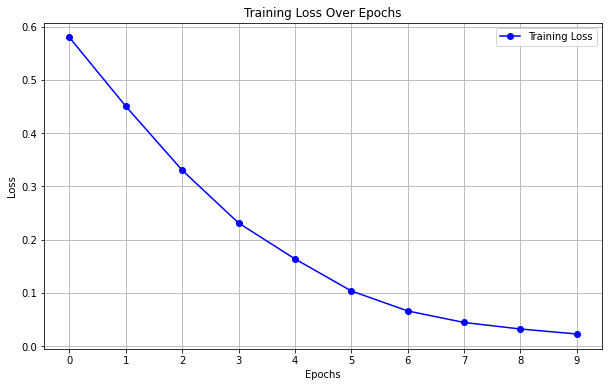

In [36]:
import matplotlib.pyplot as plt
import os 

plot_dir = "Images"
os.makedirs(plot_dir, exist_ok=True)  # Create directory if it doesn't exist

# Filename for the plot image
plot_filename = os.path.join(plot_dir, "training_loss.png")
# Plot the training loss for each epoch
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], marker='o', linestyle='-', color='blue', label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(len(history.history['loss'])))  # Ensure each epoch is marked on the x-axis
plt.grid()
plt.legend()
plt.savefig(plot_filename, format='png', dpi=300)  
plt.show()


In [26]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")


2/2 [==============================] - 0s 5ms/step - loss: 3.0208e-06 - accuracy: 1.0000
Test Accuracy: 1.00


In [37]:
# Predict win conditions on test data
predictions = model.predict(X_test)
predicted_classes = (predictions > 0.1).astype(int)  # Convert probabilities to binary (0 or 1)
print("Predictions:", predicted_classes)


2/2 [==============================] - 0s 3ms/step
Predictions: [[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]


In [12]:
model.save("rocket_league_win_predictor.h5")
# To load later:
# from tensorflow.keras.models import load_model
# model = load_model("rocket_league_win_predictor.h5")


/home/shah.adit1/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


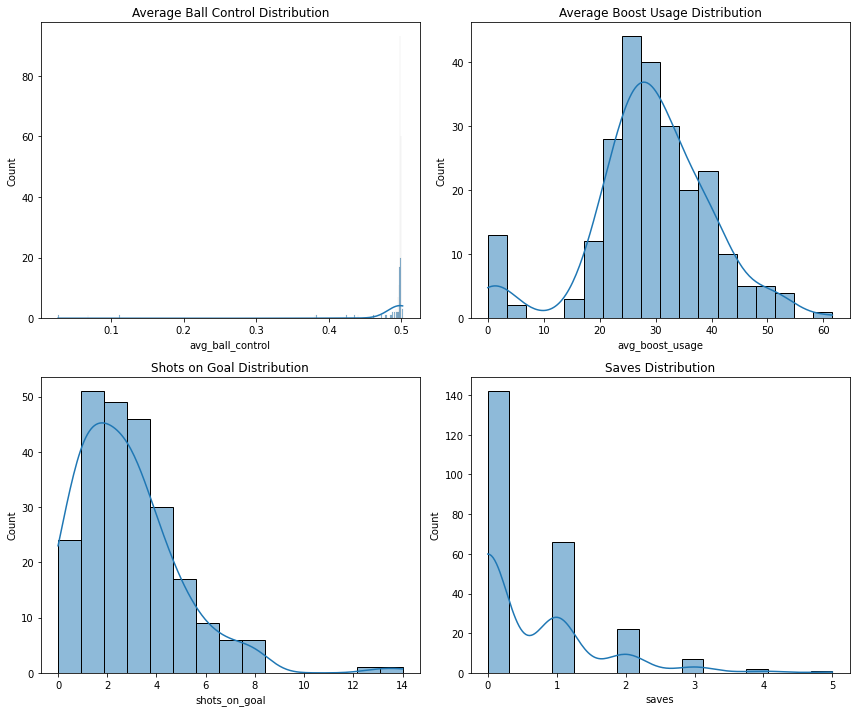

In [38]:
#EDA -Feature Enginnerring 


import matplotlib.pyplot as plt
import seaborn as sns
# Filename for the plot image
plot_filename = os.path.join(plot_dir, "EDA.png")
# Plot distributions of each feature
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
sns.histplot(final_dataset['avg_ball_control'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Average Ball Control Distribution')

sns.histplot(final_dataset['avg_boost_usage'], kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Average Boost Usage Distribution')

sns.histplot(final_dataset['shots_on_goal'], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Shots on Goal Distribution')

sns.histplot(final_dataset['saves'], kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Saves Distribution')

plt.tight_layout()
plt.savefig(plot_filename, format='png', dpi=300)  
plt.show()


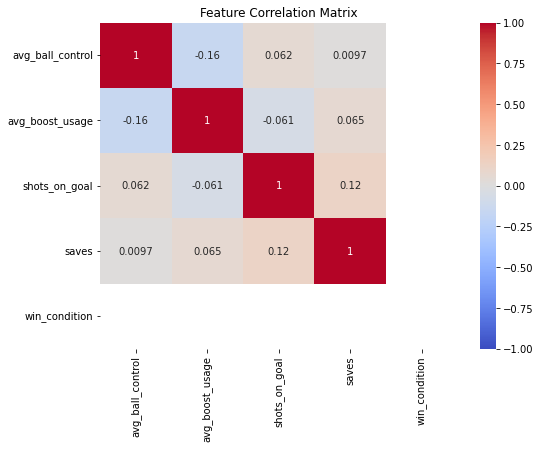

In [10]:
# Correlation matrix heatmap
# Filename for the plot image
plot_filename = os.path.join(plot_dir, "Correlation_coefficint.png")
plt.figure(figsize=(8, 6))
sns.heatmap(final_dataset.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix')
plt.savefig(plot_filename, format='png', dpi=300)  
plt.show()


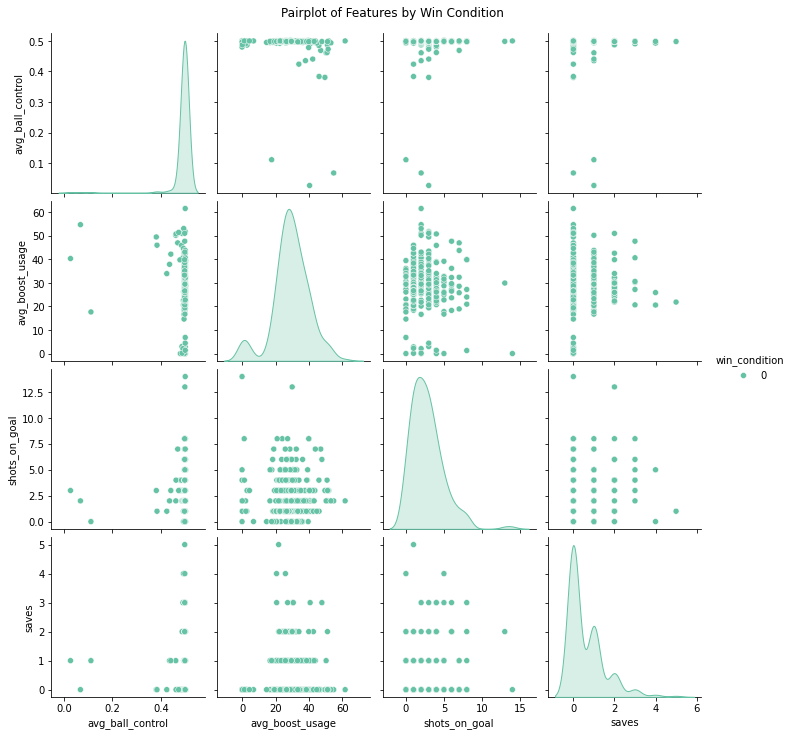

In [11]:
plot_filename = os.path.join(plot_dir, "Pp_win_condition.png")
sns.pairplot(final_dataset, hue='win_condition', palette='Set2')
plt.suptitle('Pairplot of Features by Win Condition', y=1.02)
plt.savefig(plot_filename, format='png', dpi=300)  
plt.show()


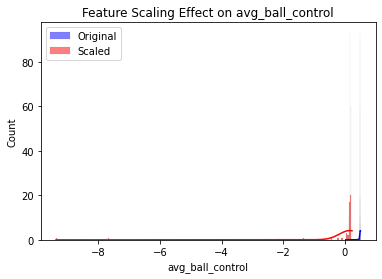

In [12]:
#Data SPliting and Visualization 
# Before scaling
sns.histplot(X['avg_ball_control'], kde=True, label='Original', color='blue')
sns.histplot(X_scaled[:, 0], kde=True, label='Scaled', color='red')
plt.title('Feature Scaling Effect on avg_ball_control')
plt.legend()
plt.show()


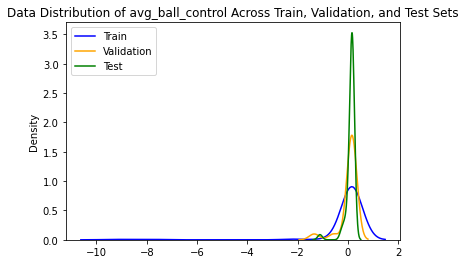

In [13]:
# KDE plots for training, validation, and test data distributions
plot_filename = os.path.join(plot_dir, "Train_Test.png")
sns.kdeplot(X_train[:, 0], label='Train', color='blue')
sns.kdeplot(X_val[:, 0], label='Validation', color='orange')
sns.kdeplot(X_test[:, 0], label='Test', color='green')
plt.title('Data Distribution of avg_ball_control Across Train, Validation, and Test Sets')
plt.legend()
plt.savefig(plot_filename, format='png', dpi=300)
plt.show()


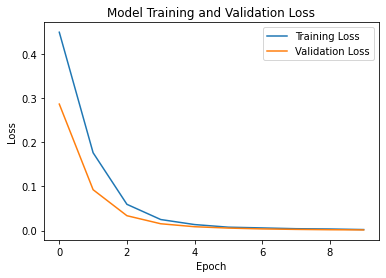

In [14]:
#model 
plot_filename = os.path.join(plot_dir, "Model_loss.png")
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(plot_filename, format='png', dpi=300)
plt.show()


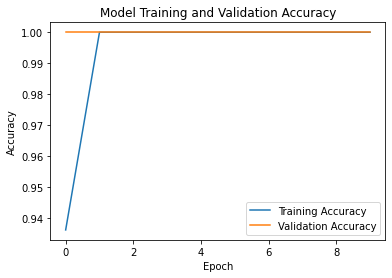

In [15]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import numpy as np

# Generate predictions on the test set
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision:.2f}")

# Recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.2f}")

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.2f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)


2/2 [==============================] - 0s 3ms/step
Accuracy: 1.00
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        48

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48


Confusion Matrix:
[[48]]


/shared/centos7/anaconda3/2021.07-TF/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/centos7/anaconda3/2021.07-TF/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/centos7/anaconda3/2021.07-TF/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
